# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
from time import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, average_precision_score, fbeta_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import aequitas as ae
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
from student_utils import *
from utils import *
pd.set_option('display.max_columns', 500)
%matplotlib inline
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

# make exact copy of df to be used later
df_copy = df.copy()

# replace "?" with NaN, and "?|?" with NaN
df = df.replace('?', np.nan).replace("?|?", np.nan)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.shape

(143424, 26)

In [6]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

#### Find the Number of Unique Encounters

In [7]:

df['encounter_id'].nunique() 

101766

#### Find the total number of rows of df

In [8]:

len(df)

143424

##### Find the total number of columns of df

In [9]:

df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

## Determine Level of Dataset (Line or Encounter)

In [10]:
df.shape, df.encounter_id.nunique(), df.patient_nbr.nunique()

((143424, 26), 101766, 71518)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:??
#### The dataset is at the line level because the number of rows is greater than the number of unique encounters


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

###### Function to find missing and zero values 

In [11]:

def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

##### Let's count the amount of null values in each column

In [12]:

df.isnull().sum()

encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes          340
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

###### Calculate missing and zero values and record them in null_df

In [13]:

null_df = check_null_values(df)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


We see that the fields with the highest missing values are weight, payer_code, medical_specialty, and ndc_code. On the other hand fields with the hightest zero values are number_outpatient, number_inpatient, number_emergency, and number_precedures.

In [14]:
# Here we include age and gender since they are divided into bins

categorical_fields = ['age', 'weight', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                      'admission_source_id', 'payer_code', 'medical_specialty',
                      'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
                      'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

In [15]:
# Function to count unique value for each column
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [16]:
# count unique value for each column and record them in val_df
val_df = count_unique_values(df, categorical_fields) 
val_df

,columns,cardinality
age,age,10
weight,weight,9
race,race,5
gender,gender,3
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716


The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field.

**Student Response**: ??

The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field.

### Remove columns with high null percentage

## Identify categorical columns

##### high cardinality columns include 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code'

##### Age distribution

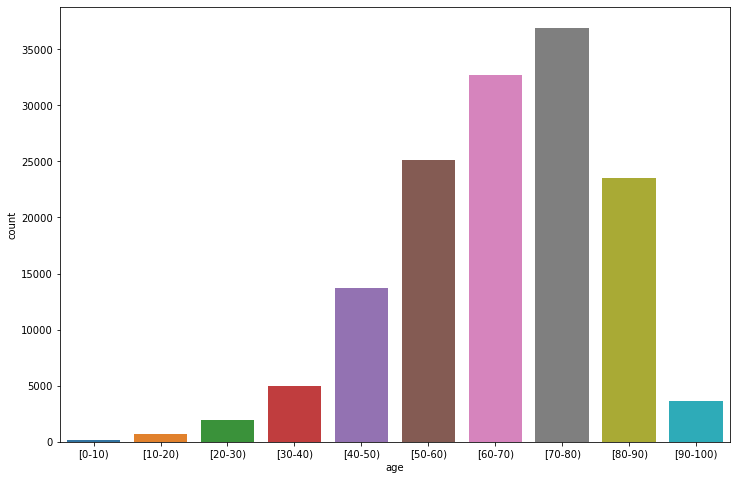

In [17]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age', data=df); 

##### Gender Distribution

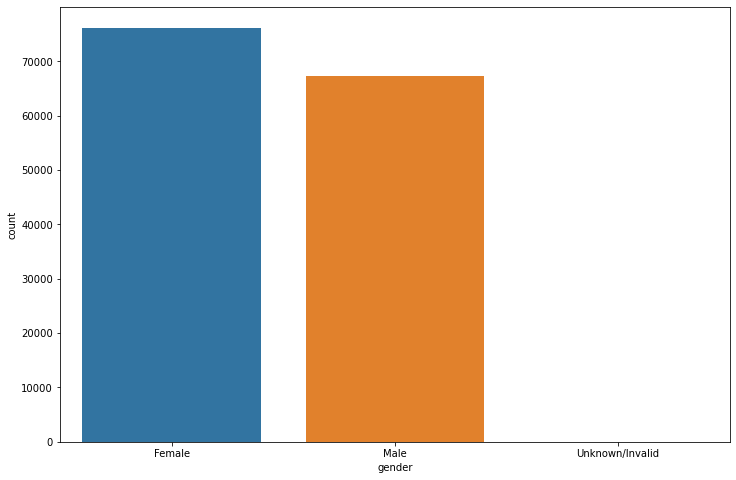

In [18]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', data=df); 

In [19]:
# See the percentage of Unknown/Invalid gender
len(df[df["gender"] == "Unknown/Invalid"])/len(df["gender"])*100

0.0034861668897813477

Student Response:

a. Fields with the highest missing values are __weight, payer_code, medical_specialty, and ndc_code. On the other hand fields with the hightest zero values are number_outpatient, number_inpatient, number_emergency, number_precedures.
b. It seems that 'num_lab_procedures' and 'num_medications' are the numberical features which has gausian or normal distribution.
c. The categorical features which has extremely high cardinality (>70) are medical_specialty, primary_diagnosis_code, other_diagnosis_code, and ndc_code. These features have high cardinality since their values represent codes which are plenty in medical field. 
d. The age distribution is left skewed with the highest peak at age 70 to 80. On the other hand, the gender distribution seems to be uniform with a slight preference toward Female. If we plot both age and gender distribution together, we see that there is a little preference toward male age age 40 to 50, 50 to 60, and 60 to 70. 

##### Distribution of age and gender

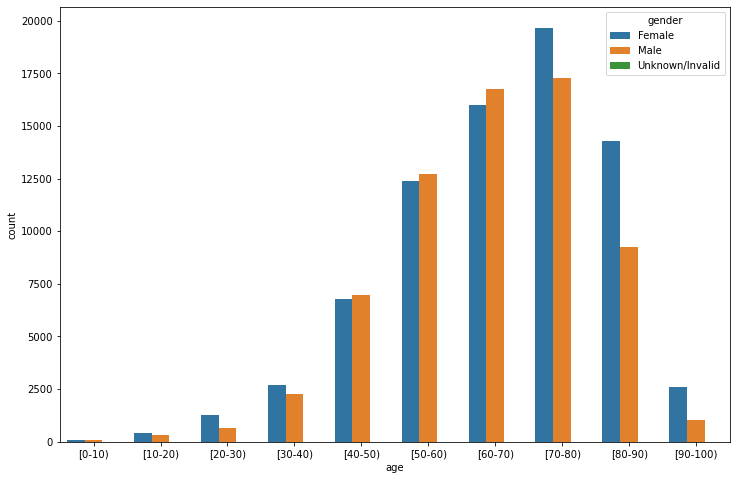

In [20]:
# distribution of age and gender
plt.figure(figsize=(12, 8))
sns.countplot(x="age", hue="gender", data=df); 

##### Time in hospital per race

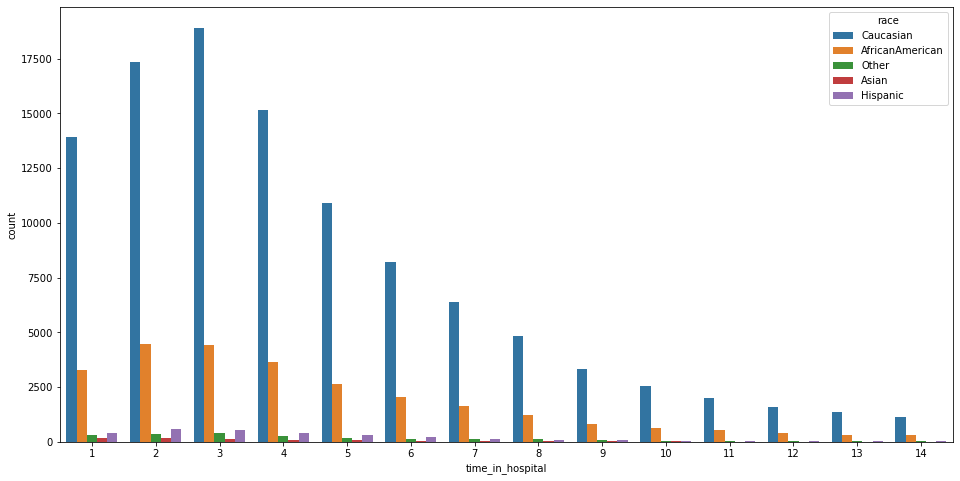

In [21]:
plt.figure(figsize=(16,8))
sns.countplot(x="time_in_hospital", hue="race", data=df)

We see the majority of the patients in the dataset is Caucasian, followed by African American, Hispanic, Other, and Asian.



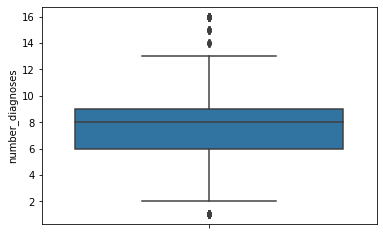

In [22]:
sns.boxplot(y = df['number_diagnoses'])

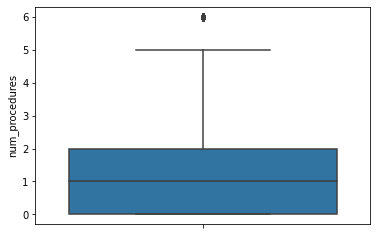

In [23]:
sns.boxplot(y = df['num_procedures'])

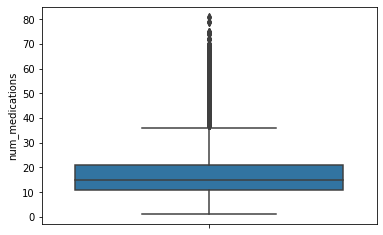

In [24]:
sns.boxplot(y = df['num_medications'])

We see that there are a lot of outliers in num_medication.

In [25]:
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures'],
      dtype='object')

In [26]:
num_col = ['time_in_hospital', 
           'number_outpatient',
           'number_inpatient', 
           'number_emergency', 
           'num_lab_procedures',
           'number_diagnoses', 
           'num_medications', 
           'num_procedures']
df[num_col].describe()

,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [27]:
# num_medications and num_lab_procecures follows normal distribution
#sns.pairplot(df[num_col]);

In [28]:
df.shape

(143424, 26)

#### From the pairplot num_medications and num_lab_procecures follows normal distribution

In [29]:
#import tensorflow_data_validation as tfdv


In [30]:
#! pip install apache-beam[interactive]

In [31]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [32]:
# Get the original df back
df = df_copy.copy()

#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [33]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


From above we see that multiple NDC_Code has the same Non-propriatary Name or generic drug name.

In [34]:
ndc_code_df.dtypes

NDC_Code                object
Proprietary Name        object
Non-proprietary Name    object
Dosage Form             object
Route Name              object
Company Name            object
Product Type            object
dtype: object

In [35]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,None,None,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,None,None,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,Human Insulin
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,Human Insulin
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,Human Insulin


In [36]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

### Aggregate Dataset and Select First Encounter for each Patient

In [37]:
# aggregate lines into encounter
non_grouped_field_list = ['generic_drug_name']
grouped_field_list = ['encounter_id', 'patient_nbr']
encounter_df = reduce_dim_df.groupby(grouped_field_list)[non_grouped_field_list] \
                            .agg(lambda x: '|'.join([y for y in x if y is not np.nan ])) \
                            .reset_index()
encounter_df.head()

,encounter_id,patient_nbr,generic_drug_name
0,12522,48330783,Glipizide|Human Insulin
1,15738,63555939,Human Insulin|Rosiglitazone Maleate
2,16680,42519267,Human Insulin|Glipizide
3,28236,89869032,Human Insulin
4,35754,82637451,Human Insulin


In [38]:
# add the rest of the columns
col = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'primary_diagnosis_code', 'other_diagnosis_codes',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures', 'change', 'readmitted']

encounter_df = pd.merge(reduce_dim_df[col], encounter_df, on=['patient_nbr','encounter_id'], how='left')
encounter_df.drop_duplicates(subset=col, inplace=True)
encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,Ch,NO,Human Insulin|Glipizide
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,Ch,NO,Human Insulin|Rosiglitazone Maleate
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,No,>30,Human Insulin


In [39]:
first_encounter_df = select_first_encounter(encounter_df)
first_encounter_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Glyburide
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,No,NO,Metformin Hcl
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,Ch,NO,Glyburide|Metformin Hcl
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,No,NO,Glimepiride
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,No,>30,Human Insulin


In [40]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


### One Hot Code

In [41]:
# first_encounter_df has alrady been aggregated in the previous step
agg_drug_df = first_encounter_df.copy()
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Glyburide
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,No,NO,Metformin Hcl
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,Ch,NO,Glyburide|Metformin Hcl
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,No,NO,Glimepiride
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,No,>30,Human Insulin


In [42]:
# normalize num_col
num_col.remove('time_in_hospital')
scaler = StandardScaler()
normalized_num_col = ['normalized_' + col for col in num_col]
scaled_data = pd.DataFrame(scaler.fit_transform(agg_drug_df[num_col]), columns=normalized_num_col)
agg_drug_df = pd.concat([agg_drug_df, scaled_data], axis=1)

In [43]:
ndc_col_list = sorted(reduce_dim_df.generic_drug_name.unique())
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide And Metformin Hcl',
 'Glyburide',
 'Glyburide And Metformin Hydrochloride',
 'Human Insulin',
 'Metformin Hcl',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole And Metformin Hydrochloride',
 'Pioglitazone',
 'Pioglitazone And Glimepiride',
 'Pioglitazone Hydrochloride And Glimepiride',
 'Repaglinide',
 'Rosiglitazone Maleate',
 'Tolazamide',
 'Tolbutamide']

In [44]:
# one hot code 'generic_drug_name'
for col in ndc_col_list:
    agg_drug_df[col]  = agg_drug_df['generic_drug_name'].apply(lambda x: 1 if col in x else 0)

In [45]:
other_dx_code = []
for x in agg_drug_df.other_diagnosis_codes.unique():
    other_dx_code.extend(x.split('|'))
other_dx_code = set(other_dx_code)
pri_dx_code = set(agg_drug_df.primary_diagnosis_code.unique())
dx_code = list(other_dx_code.union(pri_dx_code))
dx_code = sorted(set([x.split('.')[0] for x in dx_code if (x !='?') & (type(x) == type('12'))]))

In [46]:
# one hot code 'dx_code'
agg_drug_df['dx_code'] = agg_drug_df.other_diagnosis_codes + '|' + agg_drug_df.primary_diagnosis_code
agg_drug_df['dx_code'] = agg_drug_df['dx_code'].astype(str)
for col in dx_code:
    agg_drug_df[col]  = agg_drug_df['dx_code'].apply(lambda x: 1 if col in x else 0)

In [47]:
def one_hot_code(col, df):
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies.iloc[:, :-1]], axis=1)
    return (dummies.columns[:-1], df)

In [48]:
# one hot code the rest of the categorical variables
one_hot_col = []
for col in ['race','gender','age', 'change','readmitted','admission_type_id','discharge_disposition_id','admission_source_id']:
    col_name_list, agg_drug_df = one_hot_code(col, agg_drug_df)
    one_hot_col.extend(col_name_list)  

In [49]:
col_name_list


Index(['admission_source_id_1', 'admission_source_id_2',
       'admission_source_id_3', 'admission_source_id_4',
       'admission_source_id_5', 'admission_source_id_6',
       'admission_source_id_7', 'admission_source_id_8',
       'admission_source_id_9', 'admission_source_id_10',
       'admission_source_id_11', 'admission_source_id_13',
       'admission_source_id_14', 'admission_source_id_17',
       'admission_source_id_20', 'admission_source_id_22'],
      dtype='object')

In [50]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name,normalized_number_outpatient,normalized_number_inpatient,normalized_number_emergency,normalized_num_lab_procedures,normalized_number_diagnoses,normalized_num_medications,normalized_num_procedures,Acarbose,Glimepiride,Glipizide,Glipizide And Metformin Hcl,Glyburide,Glyburide And Metformin Hydrochloride,Human Insulin,Metformin Hcl,Miglitol,Nateglinide,Pioglitazole And Metformin Hydrochloride,Pioglitazone,Pioglitazone And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Repaglinide,Rosiglitazone Maleate,Tolazamide,Tolbutamide,dx_code,10,11,110,112,114,115,117,122,123,130,131,133,135,136,137,138,139,14,140,141,142,143,145,146,147,149,150,151,152,153,154,155,156,157,158,160,161,162,163,164,17,170,171,172,173,174,175,179,180,182,183,184,185,186,187,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,208,210,211,212,214,215,216,217,218,219,220,223,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,243,244,245,246,250,251,252,253,255,256,258,259,260,261,262,263,265,266,268,269,27,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,3,300,301,303,304,305,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,320,322,323,324,325,327,331,332,333,334,335,336,337,338,34,340,341,342,343,344,345,346,347,348,349,35,350,351,352,353,354,...,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,927,928,933,934,935,936,94,941,942,943,944,945,948,952,953,955,956,957,958,959,962,963,964,965,966,967,968,969,970,971,972,976,977,980,983,986,987,988,989,990,991,992,994,995,996,997,998,999,E812,E814,E816,E817,E818,E819,E821,E822,E825,E826,E828,E829,E849,E850,E853,E854,E855,E858,E868,E870,E878,E879,E880,E881,E882,E883,E884,E885,E886,E887,E888,E890,E894,E900,E904,E905,E906,E909,E915,E916,E917,E918,E919,E920,E922,E924,E927,E928,E929,E930,E931,E932,E933,E934,E935,E936,E937,E938,E939,E941,E942,E944,E946,E947,E949,E950,E955,E956,E965,E966,E968,E980,V01,V02,V03,V06,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V23,V25,V27,V42,V43,V44,V45,V46,V49,V51,V53,V54,V55,V56,V57,V58,V60,V61,V62,V63,V64,V65,V66,V67,V70,V71,V72,V85,V86,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),change_Ch,readmitted_<30,readmitted_>30,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Glyburid

In [51]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()
print("Succesfully Aggregate Dataset to Right Level for Modeling")

Succesfully Aggregate Dataset to Right Level for Modeling


## Aggregate Dataset and Select First Encounter for each Patient


**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [52]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [53]:
cat_col_list = ndc_col_list + dx_code + one_hot_col 
num_col_list = normalized_num_col
PREDICTOR_FIELD = 'time_in_hospital'
selected_features_df_sklearn = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

In [54]:
cat_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide And Metformin Hcl',
 'Glyburide',
 'Glyburide And Metformin Hydrochloride',
 'Human Insulin',
 'Metformin Hcl',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole And Metformin Hydrochloride',
 'Pioglitazone',
 'Pioglitazone And Glimepiride',
 'Pioglitazone Hydrochloride And Glimepiride',
 'Repaglinide',
 'Rosiglitazone Maleate',
 'Tolazamide',
 'Tolbutamide',
 '10',
 '11',
 '110',
 '112',
 '114',
 '115',
 '117',
 '122',
 '123',
 '130',
 '131',
 '133',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '145',
 '146',
 '147',
 '149',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '160',
 '161',
 '162',
 '163',
 '164',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '179',
 '180',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '208',
 '210',
 

In [55]:
cat_col_list =  ['generic_drug_name', 
                 'race',
                 'gender',
                 'age',
                 'primary_diagnosis_code',
                 'change',
                 'readmitted',
                 'admission_type_id',
                 'discharge_disposition_id',
                 'admission_source_id']
num_col_list = normalized_num_col
PREDICTOR_FIELD = 'time_in_hospital'
selected_features_df_tf = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

In [56]:
selected_features_df_tf

,patient_nbr,time_in_hospital,generic_drug_name,race,gender,age,primary_diagnosis_code,change,readmitted,admission_type_id,discharge_disposition_id,admission_source_id,normalized_number_outpatient,normalized_number_inpatient,normalized_number_emergency,normalized_num_lab_procedures,normalized_number_diagnoses,normalized_num_medications,normalized_num_procedures
0,135,8,Human Insulin|Metformin Hcl|Glyburide,Caucasian,Female,[50-60),401,Ch,<30,2,1,1,-0.270391,-0.326300,-0.211533,1.660744,0.359774,1.933769,2.592185
1,729,4,Metformin Hcl,Caucasian,Female,[80-90),820,No,NO,1,3,7,-0.270391,-0.326300,-0.211533,1.213230,0.862141,0.754065,0.328328
2,774,3,Glyburide|Metformin Hcl,Caucasian,Female,[80-90),274,Ch,NO,1,1,7,-0.270391,-0.326300,-0.211533,0.119308,0.862141,0.400153,-0.803600
3,927,5,Glimepiride,AfricanAmerican,Female,[30-40),590,No,NO,1,1,7,-0.270391,-0.326300,-0.211533,0.268480,-2.152065,-1.369403,-0.803600
4,1152,6,Human Insulin,AfricanAmerican,Female,[50-60),282,No,>30,1,1,7,-0.270391,1.181704,-0.211533,-0.029863,-2.654432,-0.425640,0.328328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56128,189349430,1,Glimepiride,Asian,Female,[70-80),595,No,NO,1,1,7,-0.270391,-0.326300,-0.211533,-0.626547,0.862141,-1.251433,-0.803600
56129,189365864,3,Human Insulin,Other,Male,[60-70),584,No,NO,1,1,7,-0.270391,-0.326300,-0.211533,0.616546,-0.142594,-1.015492,-0.237636
56130,189445127,3,Glipizide|Human Insulin|Rosiglitazone Maleate|...,Caucasian,Female,[80-90),486,Ch,NO,1,1,7,-0.270391,-0.326300,-0.211533,-0.228758,0.862141,0.164212,-0.803600
56131,189481478,14,Human Insulin|Glyburide|Metformin Hcl,Caucasian,Female,[40-50),295,Ch,>30,1,4,7,-0.270391,-0.326300,-0.211533,1.262954,-1.147329,-0.071728,-0.803600


Student response: ??

From the percentage of null values in each column, we see weight, payer_code, and medical_specialty have extremely high null values. Therefore, we won't include them in our model.

For the numerical fields, we will only include num_lab_procedures and num_medications since from our previous EDA, we found that they are the ones which have gausian or normal distribution.



### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [57]:
processed_df_sklearn = selected_features_df_sklearn.copy()
processed_df = selected_features_df_tf.copy()


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [58]:
d_train, d_val, d_test = patient_dataset_splitter_tf(processed_df, PREDICTOR_FIELD, 'patient_nbr')


In [59]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [60]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1      7532
2      9473
3     10028
4      7681
5      5566
6      4122
7      3231
8      2419
9      1655
10     1292
11     1054
12      807
13      702
14      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


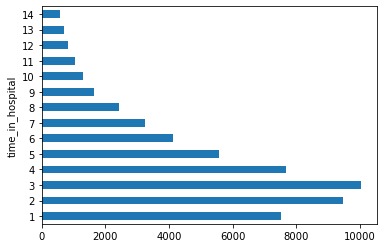

In [61]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1     4519
2     5684
3     6017
4     4608
5     3340
6     2473
7     1939
8     1451
9      993
10     775
11     632
12     484
13     421
14     343
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


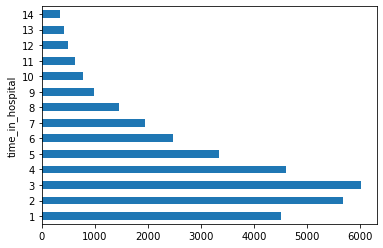

In [62]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1     1506
2     1894
3     2006
4     1537
5     1113
6      825
7      646
8      484
9      331
10     258
11     211
12     162
13     140
14     114
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


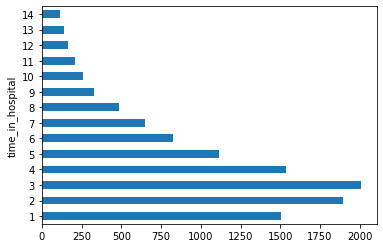

In [63]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


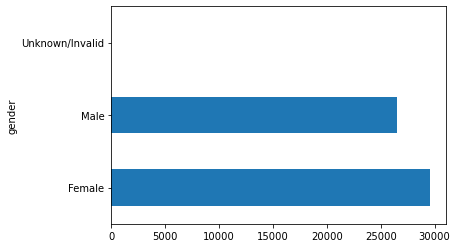

In [64]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17720
Male      15959
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


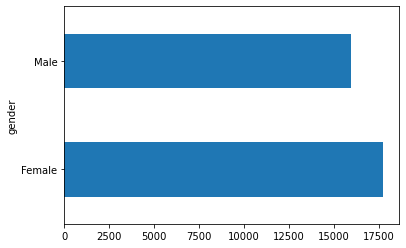

In [65]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5943
Male               5283
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


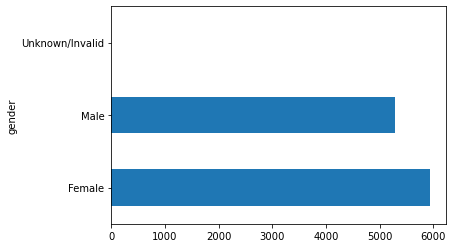

In [66]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [67]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [68]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [69]:
vocab_file_list = build_vocab_files(d_train, cat_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [70]:
tf_cat_col_list = create_tf_categorical_feature_cols(cat_col_list)

INFO:tensorflow:vocabulary_size = 469 in generic_drug_name is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/generic_drug_name_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 607 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elemen

In [71]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='generic_drug_name', vocabulary_file='./diabetes_vocab/generic_drug_name_vocab.txt', vocabulary_size=469, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
t

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [72]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [73]:
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(key=c, default_value=0, dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list
#tf_cont_col_list = create_tf_numerical_feature_cols(num_col_list)

In [74]:
tf_cont_col_list = create_tf_numerical_feature_cols(num_col_list)

In [75]:
tf.keras.backend.set_floatx('float64')

In [76]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='normalized_number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=None)

tf.Tensor(
[[ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 1.5341353 ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 1.5341353 ]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 2.4363985 ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 0.631872  ]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [77]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [78]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [79]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, claim_feature_layer,  epochs=15)


ValueError: in converted code:

    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/dense_features.py:135 call
        self._state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4351 get_dense_tensor
        return transformation_cache.get(self, state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:2615 get
        transformed = column.transform_feature(self, state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4290 transform_feature
        transformation_cache, state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3658 get_sparse_tensors
        transformation_cache.get(self, state_manager), None)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:2615 get
        transformed = column.transform_feature(self, state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3636 transform_feature
        return self._transform_input_tensor(input_tensor, state_manager)
    /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3608 _transform_input_tensor
        self.key, self.dtype, input_tensor.dtype))

    ValueError: Column dtype and SparseTensors dtype must be compatible. key: admission_source_id, column dtype: <dtype: 'string'>, tensor dtype: <dtype: 'int32'>


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [ ]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [ ]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [ ]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [ ]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [ ]:
# AUC, F1, precision and recall
# Summary

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness plot